<a href="https://colab.research.google.com/github/SD325/NASA_Internship_2020/blob/master/NASA_Data_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")
# Imports
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load Data

In [3]:
import scipy.io
BASE_DIR = '/content/drive/My Drive/data/NASA_2020/'
FILE_PATH = BASE_DIR + 'colloc_Precipflag_DPR_GMI_20170606.sav'
data = scipy.io.readsav(FILE_PATH, verbose=1)

--------------------------------------------------
Date: Fri Jun 26 14:43:54 2020
User: jgong
Host: gs613-cirrus.ndc.nasa.gov
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.7.3
--------------------------------------------------
Successfully read 14 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 11 are of type VARIABLE
--------------------------------------------------
Available variables:
 - tc [<class 'numpy.ndarray'>]
 - latc [<class 'numpy.ndarray'>]
 - lonc [<class 'numpy.ndarray'>]
 - utc [<class 'numpy.ndarray'>]
 - emis [<class 'numpy.ndarray'>]
 - emis_std [<class 'numpy.ndarray'>]
 - ts [<class 'numpy.ndarray'>]
 - clwp [<class 'numpy.ndarray'>]
 - twv [<class 'numpy.ndarray'>]
 - tysfc [<class 'numpy.ndarray'>]
 - pflag [<class 'numpy.ndarray'>]
--------------------------------------------------


* *nch* = 13 (number of channels. For channel frequency:
https://www.star.nesdis.noaa.gov/mirs/gpmgmi.php)
* *nfov* = 221 
* *nrec*: number of sweep scans for each particular day

## Variables

* **Emis**: surface emissivity, [no unit], dimension [nch*nfov *nrec]. Valid value: 0<Emis<1
* **Emis_std**: standard deviation of surface emissivity, same dimension with Emis; can be used as a quality-control for "Emis". If Emis_std is large relative to Emis value, that indicates the emissivity data might be of doubtable quality.
* **Tysfc**: surface type. Integer number, each number represents one type of surface (e.g., 1 is ocean). The value of this number has no physical meaning. Rather, it should be served as a classifier for surface. Dimension [nfov * nrec], valid value: 1,2,3, ...,13,14
* **Latc/lonc**: latitude/longitude. Unit is [degree], dimension [nfov * nrec].
* **UTC**: universal time in [hr] unit. Dimension is [nrec]. UTC is the same for each sweep (i.e., nfov).
* **Ts**: surface skin temperature. Unit [K]. dimension [nfov * nrec]. This number is only positive over land. 
* **TWV**: total column water vapor. Unit [??], dimension [nfov * nrec], valid value: [0,100]
* **CLWP**: cloud liquid water path. Unit [kg/m^2], dimension [nfov * nrec], valid value: [0, 12]
* **Tc**: brightness temperature. Unit [K], dimension [nch * nfov * nrec]. Valid value: [50-350]. This is the most important input that are purely from observations. We will try to see if we can solely rely on this variable and of course latitude/longitude/time/season for the precipitation flag prediction. 
* **PFlag**: flag of the type of precipitation. Dimension [nfov * nrec], valid value [0,1,2,3], where 0 is no precipitation, 1 is stratiform, 2 is convective and 3 is other precipitation. 


In [4]:
for var, arr in data.items():
  print(f"{var}: {arr.shape}")

tc: (44425, 221, 13)
latc: (44425, 221)
lonc: (44425, 221)
utc: (44425,)
emis: (44425, 221, 13)
emis_std: (44425, 221, 13)
ts: (44425, 221)
clwp: (44425, 221)
twv: (44425, 221)
tysfc: (44425, 221)
pflag: (44425, 221)


[1.2105556  1.2111112  1.2116667  ... 0.34694445 0.3475     0.34777778]


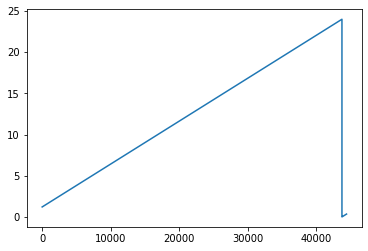

In [5]:
# plot of scan times --> drop due to reset after midnight
print(data['utc'][1:])
plt.plot(range(np.size(data['utc'][1:])), data['utc'][1:])
plt.show()

# Trim Data

In [6]:
print(data['latc'][1:, 25:196])

[[-61.262722 -61.310246 -61.3211   ... -68.70975  -68.72863  -68.78657 ]
 [-61.271713 -61.319466 -61.330498 ... -68.72192  -68.74058  -68.79808 ]
 [-61.280205 -61.328255 -61.33947  ... -68.73341  -68.75184  -68.80911 ]
 ...
 [-61.235977 -61.2829   -61.29327  ... -68.67428  -68.69376  -68.75238 ]
 [-61.24631  -61.293324 -61.30387  ... -68.68791  -68.707184 -68.765686]
 [-61.25602  -61.30317  -61.313892 ... -68.70075  -68.71981  -68.778206]]


In [7]:
data_trimmed = {}
for var, arr in data.items():
  if arr.ndim == 1:
    data_trimmed[var] = arr[1:] 
  else:
    data_trimmed[var] = arr[1:, 25:196] if arr.ndim == 2 else arr[1:, 25:196, :] 

for var, arr in data_trimmed.items():
  print(f"{var}: {arr.shape}")

tc: (44424, 171, 13)
latc: (44424, 171)
lonc: (44424, 171)
utc: (44424,)
emis: (44424, 171, 13)
emis_std: (44424, 171, 13)
ts: (44424, 171)
clwp: (44424, 171)
twv: (44424, 171)
tysfc: (44424, 171)
pflag: (44424, 171)


# Polarization Differences (PDs)

In [8]:
# calculate polarization differences (PD)
def add_to_PD(freq, ind1, ind2, data):
  PD[freq] = data['tc'][:, :, ind1] - data['tc'][:, :, ind2]

PD = {}
add_to_PD('10.65', 0, 1, data_trimmed)
add_to_PD('18.70', 2, 3, data_trimmed)
add_to_PD('36.50', 5, 6, data_trimmed)
add_to_PD('89.00', 7, 8, data_trimmed)
add_to_PD('166.0', 9, 10, data_trimmed)
print(PD.keys())

dict_keys(['10.65', '18.70', '36.50', '89.00', '166.0'])


# Construct DataFrame

In [9]:
# ravel 2d data --> scans one after another
'''
* 13 channels TB
* 3 channels PD (10.65, 89 and 166 GHz)
x Surface emissivity
* Ts
* CLWP
* TWV
* Lat/Lon
- Day of the year starting from the first day of the year (i.e., Julian day. For example, 1/1/2017 is 1, 2/1/2017 is 32)
'''
data_df = pd.DataFrame()
data_df['pflag'] = np.ravel(data_trimmed['pflag'])
data_df['lat'] = np.ravel(data_trimmed['latc'])
data_df['lon'] = np.ravel(data_trimmed['lonc'])

data_df['PD_10.65'] = np.ravel(PD['10.65'])
data_df['PD_89.00'] = np.ravel(PD['89.00'])
data_df['PD_166.0'] = np.ravel(PD['166.0'])

data_df['ts'] = np.ravel(data_trimmed['ts'])
data_df['clwp'] = np.ravel(data_trimmed['clwp'])
data_df['twv'] = np.ravel(data_trimmed['twv'])
# data_df['tysfc'] = np.ravel(data_trimmed['tysfc'])  # categorical --> add later!

for i in range(data_trimmed['tc'].shape[2]):
  data_df[f'tc_{i}'] = np.ravel(data_trimmed['tc'][:, :, i])
  data_df[f'emis_{i}'] = np.ravel(data_trimmed['emis'][:, :, i])
  data_df[f'emis_std_{i}'] = np.ravel(data_trimmed['emis_std'][:, :, i])

data_df.head()

,pflag,lat,lon,PD_10.65,PD_89.00,PD_166.0,ts,clwp,twv,tc_0,emis_0,emis_std_0,tc_1,emis_1,emis_std_1,tc_2,emis_2,emis_std_2,tc_3,emis_3,emis_std_3,tc_4,emis_4,emis_std_4,tc_5,emis_5,emis_std_5,tc_6,emis_6,emis_std_6,tc_7,emis_7,emis_std_7,tc_8,emis_8,emis_std_8,tc_9,emis_9,emis_std_9,tc_10,emis_10,emis_std_10,tc_11,emis_11,emis_std_11,tc_12,emis_12,emis_std_12
0,NaN,-61.262722,-49.823647,47.650009,8.110001,2.419983,-99.0,-99.0,-99.0,222.300003,-9999.990234,-99.0,174.649994,-9999.990234,-99.0,231.169998,-9999.990234,-99.0,193.610001,-9999.990234,-99.0,235.429993,-9999.990234,-99.0,238.149994,-9999.990234,-99.0,211.759995,-9999.990234,-99.0,254.389999,-9999.990234,-99.0,246.279999,-9999.990234,-99.0,264.049988,-9999.990234,-99.0,261.630005,-9999.990234,-99.0,252.940002,-9999.990234,-99.0,261.170013,-9999.990234,-99.0
1,NaN,-61.310246,-49.962563,53.330002,15.250000,1.470001,-99.0,-99.0,-99.0,212.520004,-9999.990234,-99.0,159.190002,-9999.990234,-99.0,217.690002,-9999.990234,-99.0,167.339996,-9999.990234,-99.0,225.220001,-9999.990234,-99.0,230.940002,-9999.990234,-99.0,194.199997,-9999.990234,-99.0,254.550003,-9999.990234,-99.0,239.300003,-9999.990234,-99.0,263.019989,-9999.990234,-99.0,261.549988,-9999.990234,-99.0,253.279999,-9999.990234,-99.0,259.709991,-9999.990234,-99.0
2,NaN,-61.321098,-50.057407,57.619995,20.430008,4.459991,-99.0,-99.0,-99.0,204.029999,-9999.990234,-99.0,146.410004,-9999.990234,-99.0,207.300003,-9999.990234,-99.0,149.770004,-9999.990234,-99.0,218.029999,-9999.990234,-99.0,226.020004,-9999.990234,-99.0,180.679993,-9999.990234,-99.0,252.740005,-9999.990234,-99.0,232.309998,-9999.990234,-99.0,263.519989,-9999.990234,-99.0,259.059998,-9999.990234,-99.0,252.559998,-9999.990234,-99.0,260.179993,-9999.990234,-99.0
3,NaN,-61.366501,-50.097477,60.279999,26.729996,3.619995,-99.0,-99.0,-99.0,199.279999,-9999.990234,-99.0,139.000000,-9999.990234,-99.0,203.759995,-9999.990234,-99.0,145.809998,-9999.990234,-99.0,215.550003,-9999.990234,-99.0,223.580002,-9999.990234,-99.0,176.380005,-9999.990234,-99.0,249.259995,-9999.990234,-99.0,222.529999,-9999.990234,-99.0,262.260010,-9999.990234,-99.0,258.640015,-9999.990234,-99.0,253.940002,-9999.990234,-99.0,260.359985,-9999.990234,-99.0
4,NaN,-61.379467,-50.191345,58.820007,23.729996,5.030029,-99.0,-99.0,-99.0,200.050003,-9999.990234,-99.0,141.229996,-9999.990234,-99.0,205.940002,-9999.990234,-99.0,149.240005,-9999.990234,-99.0,217.690002,-9999.990234,-99.0,225.679993,-9999.990234,-99.0,180.610001,-9999.990234,-99.0,250.669998,-9999.990234,-99.0,226.940002,-9999.990234,-99.0,262.140015,-9999.990234,-99.0,257.109985,-9999.990234,-99.0,252.940002,-9999.990234,-99.0,261.010010,-9999.990234,-99.0


In [10]:
data_df[(~np.isnan(data_df['pflag'])) & (data_df['ts'] != -99.0)]

,pflag,lat,lon,PD_10.65,PD_89.00,PD_166.0,ts,clwp,twv,tc_0,emis_0,emis_std_0,tc_1,emis_1,emis_std_1,tc_2,emis_2,emis_std_2,tc_3,emis_3,emis_std_3,tc_4,emis_4,emis_std_4,tc_5,emis_5,emis_std_5,tc_6,emis_6,emis_std_6,tc_7,emis_7,emis_std_7,tc_8,emis_8,emis_std_8,tc_9,emis_9,emis_std_9,tc_10,emis_10,emis_std_10,tc_11,emis_11,emis_std_11,tc_12,emis_12,emis_std_12
6219,0.0,-63.970222,-44.958664,46.440002,13.149994,2.550003,269.916016,0.069215,7.392964,245.919998,0.908059,0.003015,199.479996,0.726606,0.003059,236.410004,0.865715,0.002719,196.220001,0.701182,0.002962,233.960007,0.842837,0.242735,223.070007,0.795762,0.002232,193.190002,0.660226,0.002802,227.559998,0.780168,0.005325,214.410004,0.706191,0.007223,252.880005,0.826818,0.021811,250.330002,0.791535,0.025900,252.550003,0.826818,0.021811,260.859985,0.826818,0.021811
6220,0.0,-64.060516,-45.017330,48.970001,19.000000,5.559998,269.917816,0.070007,7.295566,246.220001,0.909243,0.003012,197.250000,0.717950,0.003058,236.199997,0.864737,0.002722,192.419998,0.685885,0.002951,231.759995,0.833515,0.252005,223.720001,0.798817,0.002215,191.770004,0.654149,0.002782,226.539993,0.775590,0.005299,207.539993,0.669312,0.007777,250.630005,0.803481,0.023645,245.070007,0.730371,0.031825,253.000000,0.803481,0.023645,260.149994,0.803481,0.023645
6221,0.0,-64.105881,-45.044941,48.649994,14.860001,6.599991,269.924072,0.071173,7.393708,245.429993,0.906147,0.003012,196.779999,0.716086,0.003057,235.919998,0.863598,0.002709,188.669998,0.670363,0.002997,232.839996,0.837873,0.259686,223.850006,0.799362,0.002224,195.279999,0.669786,0.002751,223.919998,0.760571,0.005609,209.059998,0.677117,0.007660,251.309998,0.811986,0.022951,244.710007,0.724411,0.032679,252.990005,0.811986,0.022951,259.760010,0.811986,0.022951
6256,0.0,-65.920784,-45.132149,27.129990,10.250000,2.050003,270.087494,0.144744,8.787667,252.619995,0.933586,0.003015,225.490005,0.827265,0.003058,245.110001,0.900252,0.002697,214.339996,0.773305,0.002862,241.229996,0.872894,0.207682,228.350006,0.818223,0.002222,208.919998,0.729246,0.002659,224.759995,0.757539,0.005899,214.509995,0.697658,0.007561,248.699997,0.746095,0.031421,246.649994,0.712070,0.035684,248.740005,0.746095,0.031421,257.279999,0.746095,0.031421
6257,0.0,-65.966667,-45.107044,25.029999,10.630005,2.980011,270.080017,0.146130,8.735859,253.080002,0.935396,0.003014,228.050003,0.837256,0.003057,246.460007,0.905960,0.002701,216.509995,0.782214,0.002856,244.440002,0.887527,0.234772,231.550003,0.832836,0.002176,211.410004,0.740598,0.002624,227.520004,0.773814,0.005558,216.889999,0.711754,0.007268,247.820007,0.733539,0.032815,244.839996,0.684867,0.038740,249.250000,0.733539,0.032815,257.329987,0.733539,0.032815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7596094,0.0,-65.657372,-47.461845,49.419998,9.520004,2.320007,267.878723,0.018739,6.328404,244.660004,0.910379,0.003038,195.240005,0.715921,0.003078,228.110001,0.839629,0.002732,185.610001,0.665308,0.002914,221.399994,0.797052,0.149018,205.410004,0.724400,0.002300,180.470001,0.610910,0.002736,215.059998,0.726587,0.005366,205.539993,0.674016,0.006664,246.050003,0.794685,0.020793,243.729996,0.767868,0.023285,253.380005,0.794685,0.020793,258.079987,0.794685,0.020793
7596095,0.0,-65.704292,-47.453133,46.660004,9.050003,2.160004,267.880737,0.018792,6.429471,245.500000,0.913655,0.003036,198.839996,0.730021,0.003080,230.259995,0.848322,0.002722,188.399994,0.676587,0.002904,223.669998,0.806981,0.160478,209.309998,0.741855,0.002276,182.940002,0.621857,0.002746,217.740005,0.740345,0.005212,208.690002,0.690204,0.006487,247.250000,0.803924,0.020269,245.089996,0.777972,0.022739,252.990005,0.803924,0.020269,258.600006,0.803924,0.020269
7596096,0.0,-65.751160,-47.443020,47.009995,9.840012,2.059998,267.882080,0.018844,6.379723,247.250000,0.920509,0.003034,200.240005,0.735512,0.003078,231.899994,0.855047,0.00272